<a href="https://colab.research.google.com/github/mirtorande/muffin-vs-chihuahua/blob/main/MuffinsChihuahuas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
! pip install -qq wandb
! pip install -U tensorflow-addons
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import math
import random
from tqdm.auto import tqdm
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
# Define a config dictionary object
configs = dict(
    batch_size= 32,
    #init_learning_rate = 1e-3,
    #dropout = 0.1,
    #weight_decay = 0.0001,
    image_size = 96,
    patch_size = 4,
    architecture = 'vit',
    epochs = 50,
    loss_fn = 'binary_crossentropy',
    metrics = ['accuracy'],
    patience=3,
    start_from_epoch=5
)

# Load the data: the Muffins vs Chihuahuas dataset

## Retrieve archive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_path = "/content/drive/My Drive/Datasets/archive"

## Generate a dataset

In [ ]:
def load_datasets(config, use_val=True):
  """
  Loads Training and Test datasets
  """
  image_size = (config['image_size'], config['image_size']) # (224, 224) originally
  batch_size = config['batch_size']

  if use_val:
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        validation_split = 0.2,
        subset='both',
        shuffle=True,
        seed=1337
    )
  else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        seed=1337
    )
    val_ds = None

  test_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path + '/test',
      image_size=image_size,
      batch_size=batch_size,
      shuffle=False
  )
  return train_ds, val_ds, test_ds

In [ ]:
def dataset_split_xy(dataset):
  ds_unbatched = dataset.unbatch()
  ds_x = []
  ds_y = []
  for images, labels in ds_unbatched.map(lambda x, y: (x, y)):
    ds_x.append(images)
    ds_y.append(labels)
  ds_x = np.array(ds_x)
  ds_y = np.array(ds_y)
  return ds_x, ds_y

## Data visualization

In [ ]:
def print_class_counts(dataset):
  n_muf=0
  n_chi = 0
  for images, labels in tqdm(dataset):
    for label in labels:
      if label == 0:
        n_chi += 1
      else:
        n_muf += 1

  print(n_muf, n_chi)

In [ ]:
def show_sample_figures(images, labels):
  plt.figure(figsize=(10, 10))

  for cell in range(9):
      i = random.randint(0, len(labels)-1)
      ax = plt.subplot(3, 3, cell + 1)
      plt.imshow(images[i]/255)
      plt.title(int(labels[i]))
      plt.axis("off")

## Data augmentation and optimization

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255),
        #layers.Resizing(configs['image_size'], configs['image_size']),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(
            height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)
        ),
    ],
    name="data_augmentation",
  )

'''data_normalization = keras.Sequential(
        [
        layers.Normalization(),
    ],
    name="data_nomalization",
)'''

In [ ]:
def prefetch_datasets(*args):
  args_list = [arg for arg in args]
  # Prefetching samples in GPU memory helps maximize GPU utilization.
  for i in range(len(args_list)):
    args_list[i] = args_list[i].prefetch(tf.data.AUTOTUNE)
  return args

# Model builders

## Fully Connected Neural Network

In [ ]:
# Sources: https://stackoverflow.com/questions/46836358/keras-rgb-to-grayscale
#          https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
def greyscale(x):
  # x has shape (batch, width, height, channels)
  return (0.21 * x[:,:,:,:1]) + (0.72 * x[:,:,:,1:2]) + (0.07 * x[:,:,:,-1:])

def make_nn(config, input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  x = layers.Lambda(greyscale)(augmented)
  x = layers.Flatten(input_shape=input_shape)(x)
  x = layers.Dense(config['image_size'], activation='relu')(x)
  x = layers.Dense(config['image_size'], activation='relu')(x)
  x = layers.Dropout(config['dropout'])(x)

  if num_classes == 2:
    units = 1
  else:
    units = num_classes

  outputs = layers.Dense(units, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)
  #model.summary()

  return model

## Convolutional Neural Network

In [ ]:
def make_cnn(config, input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  augmented = data_augmentation(inputs)

  # Entry block
  x = layers.Conv2D(64, 3, strides=2, padding="same")(augmented)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(256, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(config['dropout'])(x)
  outputs = layers.Dense(units, activation=activation)(x)

  return keras.Model(inputs, outputs)

## Vision Transformer

In [ ]:
def mlp(x, hidden_units, dropout_rate):
      for units in hidden_units:
          x = layers.Dense(units, activation=tf.nn.gelu)(x)
          x = layers.Dropout(dropout_rate)(x)
      return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def show_patches(x_train, image_size, patch_size):
  plt.figure(figsize=(4, 4))
  image = x_train[np.random.choice(range(x_train.shape[0]))]
  plt.imshow(image.astype("uint8"))
  plt.axis("off")

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size=(image_size, image_size)
  )
  patches = Patches(patch_size)(resized_image)
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  print(f"Patches per image: {patches.shape[1]}")
  print(f"Elements per patch: {patches.shape[-1]}")

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))
  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy().astype("uint8"))
      plt.axis("off")

In [ ]:
train, _, _ = load_datasets(configs, use_val=False)
train_x, _ = dataset_split_xy(train)
show_patches(train_x, configs['image_size'], configs['patch_size'])

In [ ]:
# Sources:  https://keras.io/examples/vision/image_classification_with_vision_transformer/

def make_vit(config, input_shape, num_classes):
  image_size = config['image_size']
  patch_size = config['patch_size']
  num_patches = (image_size // patch_size) ** 2
  projection_dim = 64
  num_heads = 4
  transformer_units = [
      projection_dim * 2,
      projection_dim,
  ]  # Size of the transformer layers
  transformer_layers = 3
  mlp_head_units = [256, 128]  # Size of the dense layers of the final classifier

  inputs = layers.Input(shape=input_shape)

  #normalized = data_normalization(inputs)
  # Augment data.
  augmented = data_augmentation(inputs)
  # Create patches.
  patches = Patches(patch_size)(augmented)
  # Encode patches.
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer block.
  for _ in range(transformer_layers):
      # Layer normalization 1.
      x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      # Create a multi-head attention layer.
      attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=projection_dim, dropout=0.1
      )(x1, x1)
      # Skip connection 1.
      x2 = layers.Add()([attention_output, encoded_patches])
      # Layer normalization 2.
      x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
      # MLP.
      x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
      # Skip connection 2.
      encoded_patches = layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(config['dropout'])(representation)
  # Add MLP.
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=config['dropout'])
  # Classify outputs.
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes
  logits = layers.Dense(units, activation=activation)(features)
  # Create the Keras model.
  model = keras.Model(inputs=inputs, outputs=logits)
  return model


## Model Selector

In [ ]:
def make_model(config, input_shape, num_classes):
  if config['architecture'] == 'nn':
    return make_nn(config, input_shape, num_classes)
  if config['architecture'] == 'cnn':
    return make_cnn(config, input_shape, num_classes)
  if config['architecture'] == 'vit':
    return make_vit(config, input_shape, num_classes)
  raise ValueError('Invalid architecture defined in configs')

# Training and tuning

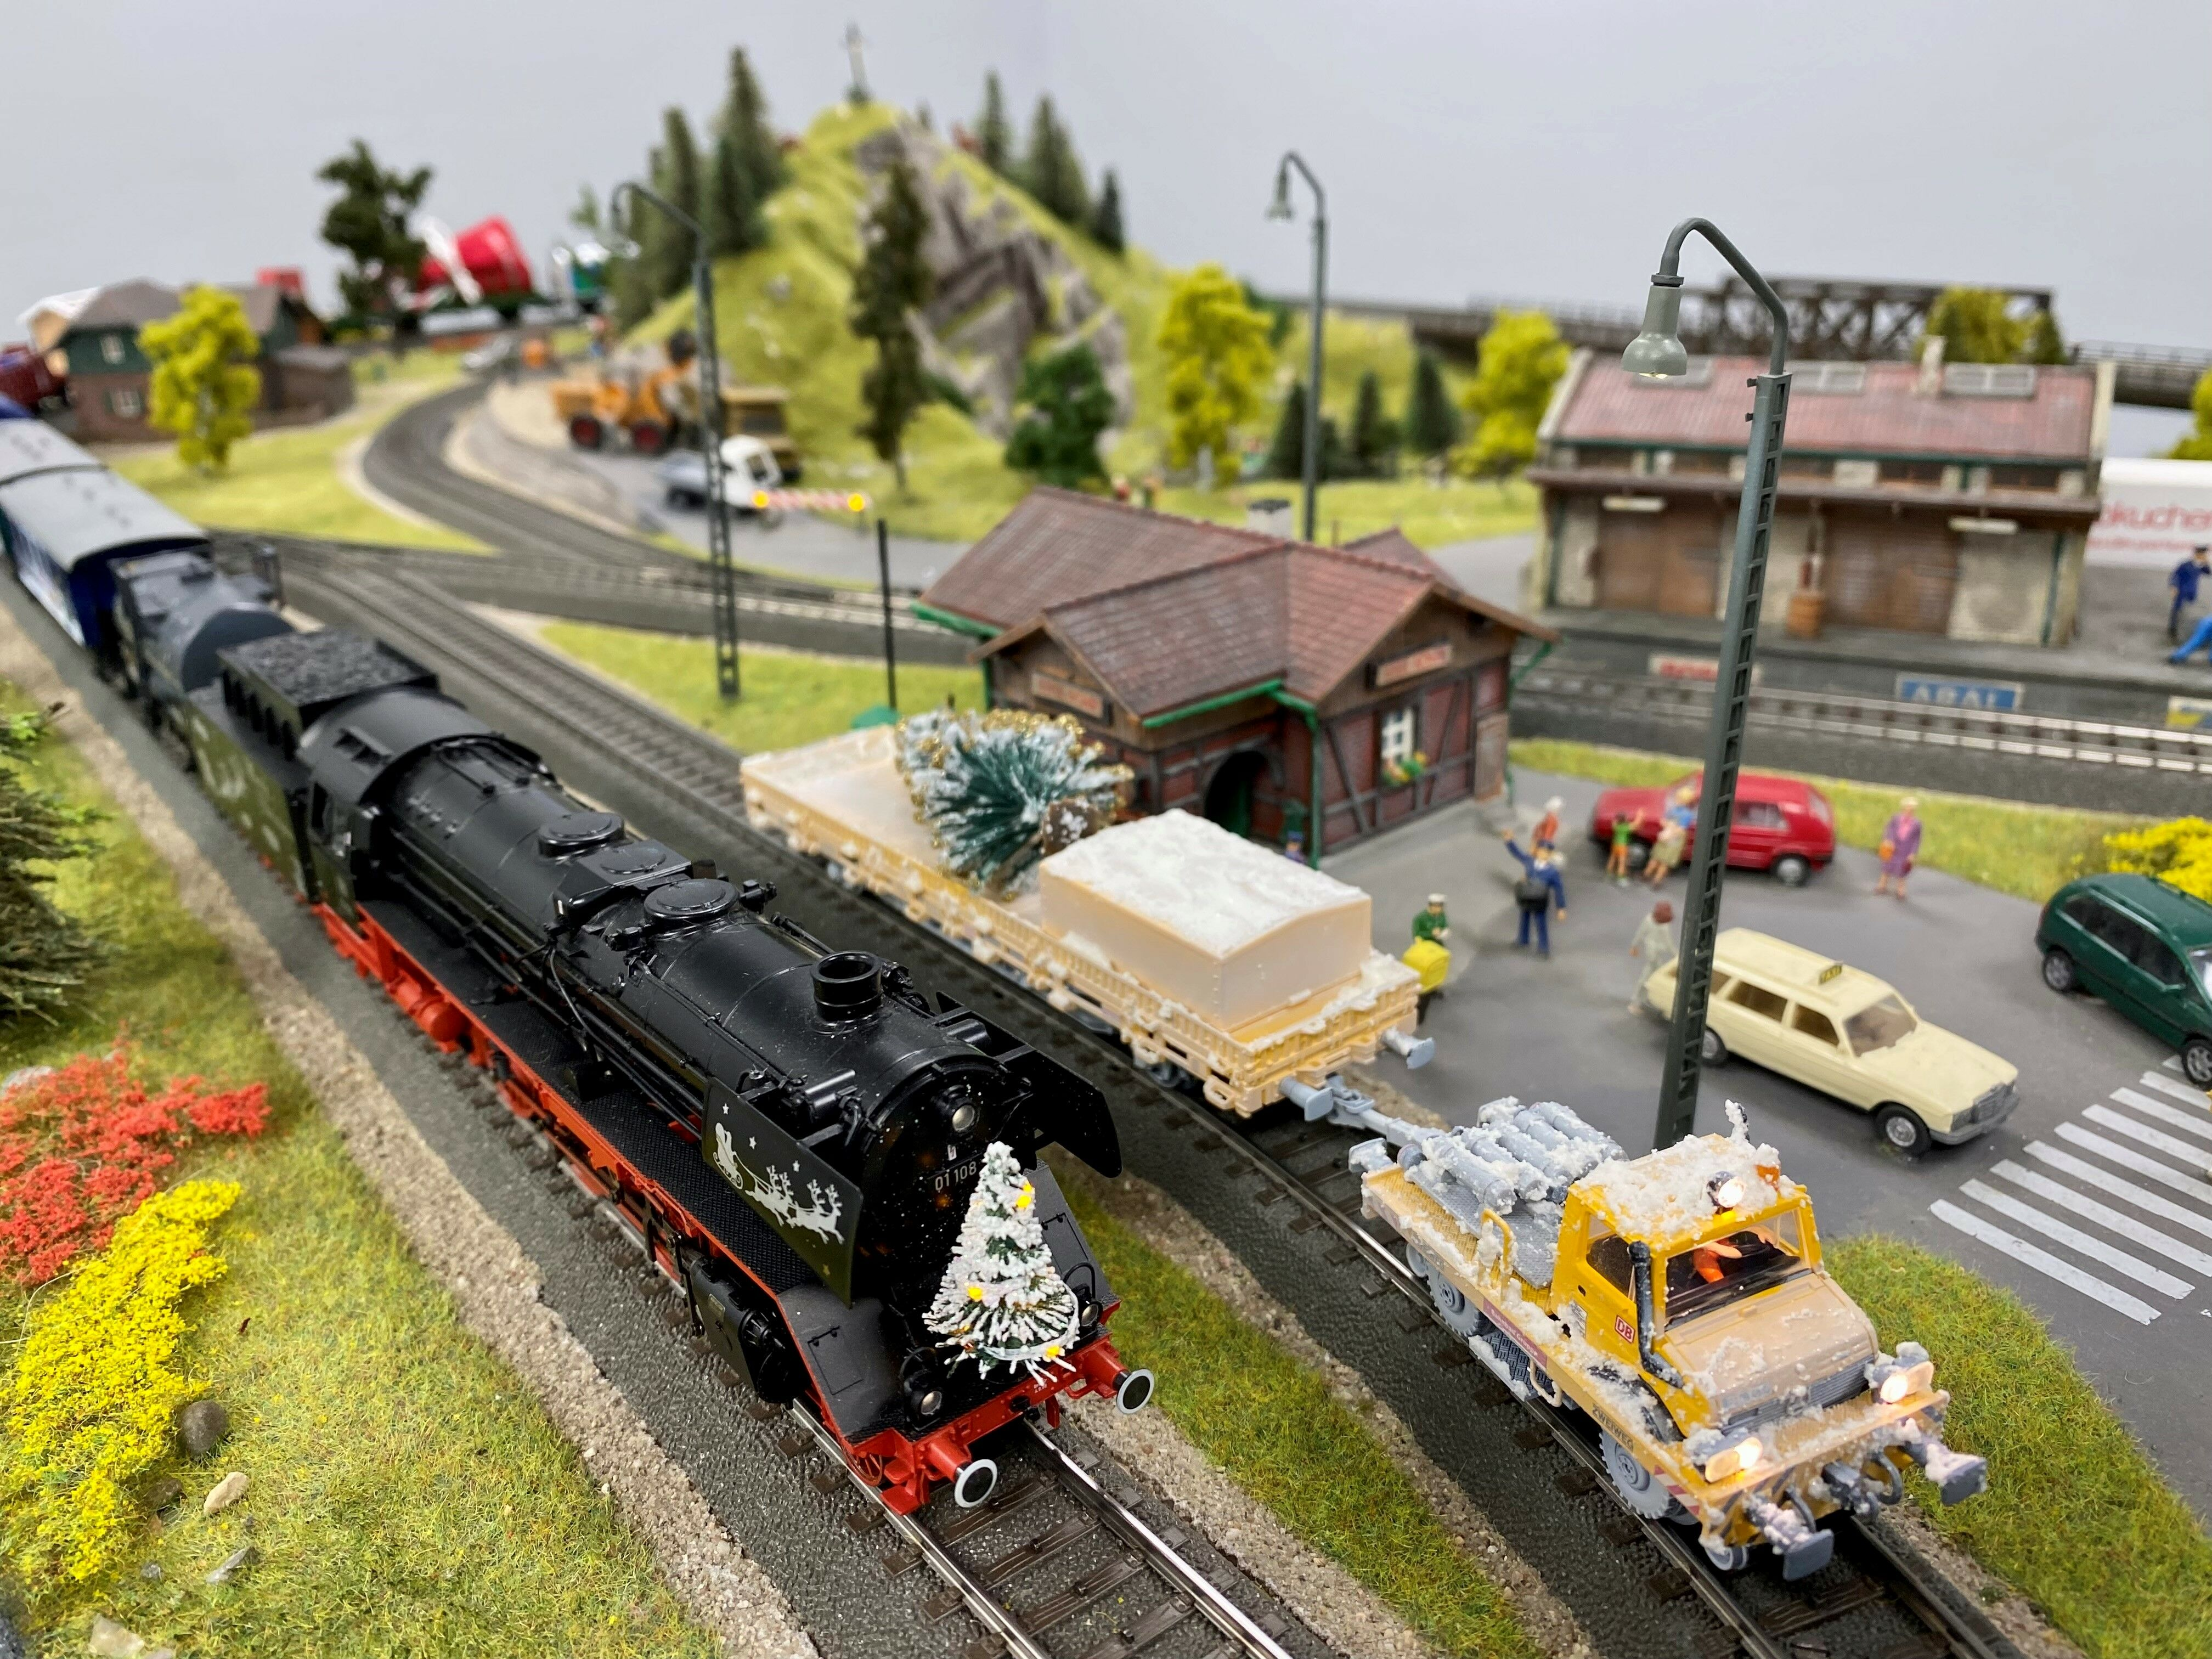

In [ ]:
def train_model(config, using_wandb=True):
  train, val, _ = load_datasets(config)
  #print_class_counts(train)
  #show_sample_figures(train)
  train, val = prefetch_datasets(train, val)
  train_x, train_y = dataset_split_xy(train)

  #data_normalization.layers[0].adapt(train_x)

  model = make_model(config, input_shape=(config['image_size'], config['image_size']) + (3,), num_classes=2)
  keras.utils.plot_model(model, show_shapes=True)

  epochs = config['epochs']

  model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=config['init_learning_rate'], weight_decay=config['weight_decay']),
    loss=config['loss_fn'],
    metrics=["accuracy"],
  )

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=config['patience'], start_from_epoch=config['start_from_epoch'], mode='max', restore_best_weights=True)

  class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, x_test):
        self.x_test = x_test

    def on_epoch_end(self, epoch, logs=None):
        print('\nEvaluating Model...')
        predictions = self.model.predict(self.x_test)
        print(predictions)
        #score = float(predictions[0])
        #print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

  x_test = keralize_img(dataset_path + '/test/muffin/img_0_67.jpg')

  performance_simple = PerformancePlotCallback(x_test)

  callbacks = [early_stopping, performance_simple]

  if using_wandb:
    wandb_log = WandbMetricsLogger(log_freq=2)
    callbacks.append(wandb_log)


  history = model.fit(
    train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val,
  )

  return model, max(history.history['val_accuracy'])

In [ ]:
def cv(config, dataset):
  # Retrieve data and labels from training set
  ds_x, ds_y = dataset_split_xy(dataset)

  accuracies = []

  for train_indexes, val_indexes in StratifiedKFold(n_splits=5).split(ds_x, ds_y):

    fold_train_x = []
    fold_train_y = []
    for i in train_indexes:
      fold_train_x.append(ds_x[i])
      fold_train_y.append(ds_y[i])

    fold_val_x = []
    fold_val_y = []
    for i in val_indexes:
      fold_val_x.append(ds_x[i])
      fold_val_y.append(ds_y[i])

    model = make_model(config, input_shape=(config['image_size'], config['image_size']) + (3,), num_classes=2)

    epochs = config['epochs']

    model.compile(
        optimizer=keras.optimizers.AdamW(config['init_learning_rate'], config['weight_decay']),
        loss=config['loss_fn'],
        metrics=config['metrics'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=config['patience'], start_from_epoch=config['start_from_epoch'], mode='max')

    callbacks = [early_stopping]

    history = model.fit(
        np.array(fold_train_x), np.array(fold_train_y),
        epochs=epochs,
        batch_size=config['batch_size'],
        callbacks=callbacks,
        validation_data=(np.array(fold_val_x), np.array(fold_val_y)),
    )
    accuracies.append(max(history.history['val_accuracy']))

  return np.mean(accuracies)

In [ ]:
def objective(config):
  return train_model(config)[1]

In [ ]:
def objective_5fold(config):
  train, _, _ = load_datasets(config, use_val=False)

  return cv(config, train)


### Sweep

In [ ]:
# 1: Define training function to run on the sweep
def main():
    wandb.init()
    val_accuracy = objective(wandb.config)
    wandb.log({'val_accuracy': val_accuracy})

# 2: Define the search space
sweep_configuration = {
    'method': 'random',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters':
    {
        'init_learning_rate': {
            'distribution': 'log_uniform_values', 'max': 1e-2, 'min': 1e-5
        },
        'batch_size': {
          # integers between 32 and 1024
          # with evenly-distributed logarithms
          'distribution': 'q_log_uniform_values',
          'q': 32,
          'min': 32,
          'max': 256,
        },
        'dropout': {
          'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
        },
        'weight_decay': {
            'distribution': 'log_uniform_values', 'max': 1e-2, 'min': 1e-5
        }
    }
}
sweep_configuration['parameters'].update({attribute:{'value':value} for attribute, value in configs.items()})

# 3: Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='MuffinChihuahuas'
)

wandb.agent(sweep_id, function=main, count=25)

# Train on best values


In [ ]:
api = wandb.Api()
sweep = api.sweep(f"minigi/MuffinChihuahuas/sweeps/{sweep_id}")

# Get best run parameters
best_run = sweep.best_run(order='val_accuracy')
best_parameters = best_run.config
print(best_parameters)

In [ ]:
best_run.summary

In [ ]:
os.system(f"wandb sweep --stop minigi/MuffinChihuahuas/{sweep_id}")
wandb.finish()

In [ ]:
train, _, test = load_datasets(best_parameters, use_val=False)
dataset = train.concatenate(test)
accuracy_estimate = cv(best_parameters, dataset)
print(f"\nFinal Accuracy Estimation: {accuracy_estimate}\n")

# Testing

In [ ]:
final_model, _ = train_model(best_parameters, using_wandb=False)
test_error = final_model.evaluate(test, return_dict=True)
print(f"\nTest Accuracy: {test_error['accuracy']}\n")

In [ ]:
def keralize_img(path):
  img = keras.utils.load_img(
    path, target_size=(configs['image_size'], configs['image_size'])
  )
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  return img_array

In [ ]:
chihuahua_img = keralize_img(dataset_path + '/test/muffin/img_0_67.jpg')
muffin_img = keralize_img(dataset_path + '/test/chihuahua/img_0_1107.jpg')

def predict(img):
  predictions = final_model.predict(img)
  score = float(predictions[0])
  print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

predict(chihuahua_img)
predict(muffin_img)

# Debug utilities

In [ ]:
test_x, test_y = dataset_split_xy(test)

for i in range(10):
  img = test_x[i]
  predictions = final_model.predict(np.reshape(img,(1,64,64,3)))
  score = float(predictions[0])
  ground_truth = test_y[i]
  print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin. and it should be {ground_truth}")
  plt.imshow(img/255)
  plt.title(int(ground_truth))
  plt.axis("off")
  plt.show()

